# **03 Baseline Model**


## Objectives

* Build a reproducible baseline machine learning pipeline using logistic regression for the intrusion detection dataset.

## Inputs

* `data/raw/cybersecurity_intrusion_data.csv`

## Outputs

* Baseline performance metrics printed within the notebook.
* A fitted scikit-learn pipeline ready for downstream experimentation.

## Additional Comments

* The notebook adopts the shared template structure to stay consistent with the rest of the project.


---


# Change working directory


* These notebooks live in the `jupyter_notebooks` subfolder, so the project root is one level up.
* Capture the current directory so we can move to the repository root before referencing project-relative paths.


In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\marka\\OneDrive\\Desktop\\Cyber\\jupyter_notebooks'

* Set the working directory to the project root so relative paths in the remaining cells resolve correctly.


In [2]:
os.chdir(os.path.dirname(current_dir))
print(f"You set a new current directory: {os.getcwd()}")

You set a new current directory: c:\Users\marka\OneDrive\Desktop\Cyber


* Double-check the update before continuing.


In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\marka\\OneDrive\\Desktop\\Cyber'

---


# Data Loading
* Load the intrusion detection dataset and perform a quick sanity check on its structure.


In [4]:
import pandas as pd

DATA_PATH = 'data/processed/cybersecurity_intrusion_data_eda.csv'
df = pd.read_csv(DATA_PATH)
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (8807, 15)


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,session_duration_log,ip_reputation_score_log,network_packet_size_is64,fail_ratio
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1,6.202502,0.474256,False,0.250000
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0,7.351798,0.263570,False,0.000000
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1,4.331316,0.553405,False,0.666667
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1,6.400671,0.116242,False,0.000000
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0,6.279536,0.053421,False,0.200000


In [9]:
df.drop(columns=['session_id', 'network_packet_size', 'session_duration', 'ip_reputation_score'], inplace=True)


# Feature Preparation
Remove identifier columns, separate the target, and catalogue numeric versus categorical predictors for preprocessing.


In [11]:
target_col = 'attack_detected'
id_cols = ['session_id']
feature_frame = df.drop(columns=[target_col])
target = df[target_col]
numeric_features = feature_frame.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = feature_frame.select_dtypes(include=['object']).columns.tolist()
print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

Numeric features: ['login_attempts', 'failed_logins', 'unusual_time_access', 'session_duration_log', 'ip_reputation_score_log', 'fail_ratio']
Categorical features: ['protocol_type', 'encryption_used', 'browser_type']


# Train/Test Split and Pipeline Definition
Split the data with stratification to keep class balance and define a preprocessing + logistic regression pipeline.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    feature_frame,
    target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

baseline_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]
)

# Model Training and Evaluation
Fit the pipeline and capture straightforward metrics to benchmark future experiments.


In [13]:
from sklearn.metrics import accuracy_score, classification_report

baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Baseline accuracy: {accuracy:.3f}')
print('Classification report:')
print(classification_report(y_test, y_pred))

Baseline accuracy: 0.750
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1012
           1       0.73      0.66      0.69       750

    accuracy                           0.75      1762
   macro avg       0.75      0.74      0.74      1762
weighted avg       0.75      0.75      0.75      1762



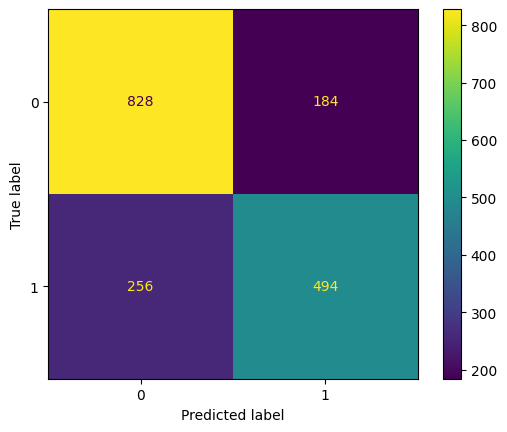

In [14]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline_pipeline, X_test, y_test)
import matplotlib.pyplot as plt
plt.show()

## The confusion matrix shows:

- True negatives: 828
- False positives: 184
- False negatives: 256
- True positives: 494

That means the model correctly classified most normal cases but missed some positives (256 false negatives).
Precision is decent, but recall for the positive class is lower. can be improved by:
- Adjusting the decision threshold
- Using class weighting (class_weight='balanced' in LogisticRegression)
- Trying models like RandomForest or XGBoost for better recall balance.

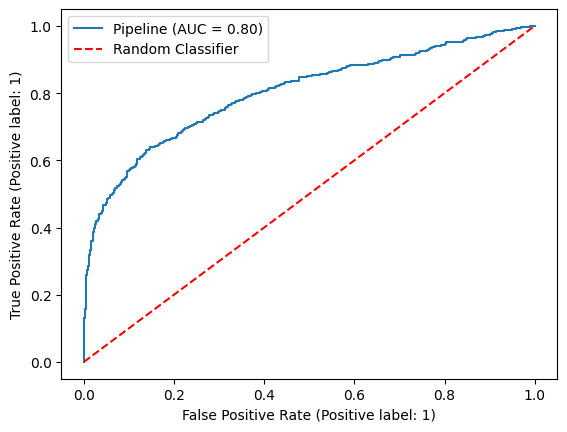

In [16]:
# ROC AUC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(baseline_pipeline, X_test, y_test)
# add the random classifier line
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier', color='red')
plt.legend()
plt.show()

In [ ]:
# write the predictions to a csv file
output_df = X_test.copy()
output_df['true_label'] = y_test
output_df['predicted_label'] = baseline_pipeline.predict(X_test)
output_df.to_csv('data/processed/cybersecurity_intrusion_predictions.csv', index=False)
# can we get a probability score for the predictions?
output_df['predicted_proba'] = baseline_pipeline.predict_proba(X_test)[:, 1]
output_df.to_csv('data/processed/cybersecurity_intrusion_predictions_with_proba.csv', index=False)
print("Predictions with probabilities saved to 'data/processed/cybersecurity_intrusion_predictions_with_proba.csv'")
print("Predictions saved to 'data/processed/cybersecurity_intrusion_predictions.csv'")

---


# Conclusions and Next Steps
* Logistic regression establishes a baseline accuracy that will anchor future model comparisons.
* Consider exploring feature interactions or more expressive models (e.g., tree ensembles) to improve recall for the attack class.
* Persist the fitted pipeline to disk once its performance is validated against additional evaluation metrics.
